In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [6]:
# Path
from google.colab import drive
drive.mount('/content/drive')
train_dir = '/content/drive/My Drive/Colab Notebooks/dataset/train'
test_dir = '/content/drive/My Drive/Colab Notebooks/dataset/test'


Mounted at /content/drive


In [7]:
img_size = (224, 224)  # VGG16 requires 224x224
batch_size = 32  # Reduced batch size for better memory management
num_classes = 5

In [8]:
# ======================
# Advanced Data Pipeline
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 520 images belonging to 5 classes.
Found 98 images belonging to 5 classes.


In [10]:
# ======================
# Class Balancing
# ======================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [11]:
# VGG16 Model
# ======================
def build_vgg_model():
    # Load pre-trained VGG16
    base_model = applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=img_size + (3,)
    )

    # Freeze initial layers, unfreeze last 3 conv blocks
    for layer in base_model.layers[:15]:
        layer.trainable = False  # Freeze first 15 layers
    for layer in base_model.layers[15:]:
        layer.trainable = True   # Unfreeze last 3 conv blocks

    # Custom classification head
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu', kernel_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.7)(x)  # Increased dropout for regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(base_model.input, outputs)

    # Use SGD optimizer for better convergence with VGG
    optimizer = optimizers.SGD(
        learning_rate=0.001,
        momentum=0.9,
        nesterov=True
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_vgg_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,564,869 (105.15 MB)

 Trainable params: 19,928,581 (76.02 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [12]:
# ======================
# Training Configuration
# ======================
callbacks = [
    ModelCheckpoint(
        'best_vgg_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,  # Increased patience for VGG
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # More conservative learning rate reduction
        patience=5,
        min_lr=1e-7
    )
]

In [13]:
# ======================
# Model Training
# ======================
# Two-phase training for better convergence
# Phase 1: Train only the top layers
history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2610 - loss: 12.3004 
Epoch 1: val_accuracy improved from -inf to 0.21875, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 345s 21s/step - accuracy: 0.2676 - loss: 12.2833 - val_accuracy: 0.2188 - val_loss: 18.0593 - learning_rate: 0.0010
Epoch 2/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4062 - loss: 12.0065

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.21875
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4062 - loss: 12.0065 - val_accuracy: 0.2188 - val_loss: 18.6490 - learning_rate: 0.0010
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.5245 - loss: 11.6355 
Epoch 3: val_accuracy improved from 0.21875 to 0.37500, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5253 - loss: 11.6294 - val_accuracy: 0.3750 - val_loss: 14.0039 - learning_rate: 0.0010
Epoch 4/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5938 - loss: 11.0990
Epoch 4: val_accuracy did not improve from 0.37500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5938 - loss: 11.0990 - val_accuracy: 0.3646 - val_loss: 13.9512 - learning_rate: 0.0010
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6439 - loss: 11.0389
Epoch 5: val_accuracy improved from 0.37500 to 0.40625, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6437 - loss: 11.0424 - val_accuracy: 0.4062 - val_loss: 14.1229 - learning_rate: 0.0010
Epoch 6/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5000 - loss: 11.2989
Epoch 6: val_accuracy did not improve from 0.40625
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5000 - loss: 11.2989 - val_accuracy: 0.4062 - val_loss: 14.2618 - learning_rate: 0.0010
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.7122 - loss: 10.8413
Epoch 7: val_accuracy did not improve from 0.40625
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7107 - loss: 10.8427 - val_accuracy: 0.3854 - val_loss: 13.0771 - learning_rate: 0.0010
Epoch 8/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.6562 - loss: 10.6798
Epoch 8: val_accuracy did not improve from 0.40625
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.6562 - loss: 10.6798 - val_accuracy: 0.3750 - val_loss: 13.2327 - learning_rate: 0.0010
Epoch 9/30
16/16 ━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7166 - loss: 10.5683 - val_accuracy: 0.5833 - val_loss: 12.2940 - learning_rate: 0.0010
Epoch 12/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.8438 - loss: 10.4395
Epoch 12: val_accuracy improved from 0.58333 to 0.61458, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8438 - loss: 10.4395 - val_accuracy: 0.6146 - val_loss: 12.1040 - learning_rate: 0.0010
Epoch 13/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.7624 - loss: 10.4587
Epoch 13: val_accuracy improved from 0.61458 to 0.69792, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7616 - loss: 10.4607 - val_accuracy: 0.6979 - val_loss: 10.9156 - learning_rate: 0.0010
Epoch 14/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.7812 - loss: 10.4132
Epoch 14: val_accuracy did not improve from 0.69792
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.7812 - loss: 10.4132 - val_accuracy: 0.6979 - val_loss: 10.9635 - learning_rate: 0.0010
Epoch 15/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.7397 - loss: 10.4636
Epoch 15: val_accuracy did not improve from 0.69792
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7414 - loss: 10.4628 - val_accuracy: 0.6458 - val_loss: 11.1827 - learning_rate: 0.0010
Epoch 16/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.8125 - loss: 10.1470
Epoch 16: val_accuracy did not improve from 0.69792
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8125 - loss: 10.1470 - val_accuracy: 0.6354 - val_loss: 11.2793 - learning_rate: 0.0010
Epoch 17/30
16

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7648 - loss: 10.1873 - val_accuracy: 0.7812 - val_loss: 10.5071 - learning_rate: 5.0000e-04
Epoch 20/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.7812 - loss: 10.3588
Epoch 20: val_accuracy did not improve from 0.78125
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7812 - loss: 10.3588 - val_accuracy: 0.7396 - val_loss: 10.5034 - learning_rate: 5.0000e-04
Epoch 21/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8130 - loss: 10.0909
Epoch 21: val_accuracy improved from 0.78125 to 0.79167, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8126 - loss: 10.0918 - val_accuracy: 0.7917 - val_loss: 10.2073 - learning_rate: 5.0000e-04
Epoch 22/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9062 - loss: 9.8232
Epoch 22: val_accuracy did not improve from 0.79167
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9062 - loss: 9.8232 - val_accuracy: 0.7812 - val_loss: 10.2054 - learning_rate: 5.0000e-04
Epoch 23/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8188 - loss: 10.0332
Epoch 23: val_accuracy improved from 0.79167 to 0.81250, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8193 - loss: 10.0323 - val_accuracy: 0.8125 - val_loss: 10.0292 - learning_rate: 5.0000e-04
Epoch 24/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.8438 - loss: 9.8056
Epoch 24: val_accuracy improved from 0.81250 to 0.82292, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8438 - loss: 9.8056 - val_accuracy: 0.8229 - val_loss: 10.0016 - learning_rate: 5.0000e-04
Epoch 25/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.8593 - loss: 9.8909
Epoch 25: val_accuracy did not improve from 0.82292
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8580 - loss: 9.8943 - val_accuracy: 0.7917 - val_loss: 10.0447 - learning_rate: 5.0000e-04
Epoch 26/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.8438 - loss: 9.7303
Epoch 26: val_accuracy did not improve from 0.82292
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8438 - loss: 9.7303 - val_accuracy: 0.7917 - val_loss: 10.0761 - learning_rate: 5.0000e-04
Epoch 27/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.8453 - loss: 9.9079
Epoch 27: val_accuracy improved from 0.82292 to 0.85417, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8442 - loss: 9.9084 - val_accuracy: 0.8542 - val_loss: 9.9363 - learning_rate: 5.0000e-04
Epoch 28/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.9062 - loss: 9.6956
Epoch 28: val_accuracy improved from 0.85417 to 0.86458, saving model to best_vgg_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9062 - loss: 9.6956 - val_accuracy: 0.8646 - val_loss: 9.9182 - learning_rate: 5.0000e-04
Epoch 29/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.8474 - loss: 9.8225
Epoch 29: val_accuracy did not improve from 0.86458
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8463 - loss: 9.8266 - val_accuracy: 0.7708 - val_loss: 10.0553 - learning_rate: 5.0000e-04
Epoch 30/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.8750 - loss: 9.6241
Epoch 30: val_accuracy did not improve from 0.86458
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8750 - loss: 9.6241 - val_accuracy: 0.7812 - val_loss: 10.1009 - learning_rate: 5.0000e-04


In [14]:
# Phase 2: Fine-tune the entire model
for layer in model.layers:
    layer.trainable = True  # Unfreeze all layers

model.compile(
    optimizer=optimizers.SGD(0.0001, momentum=0.9),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    initial_epoch=30,
    epochs=100,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 31/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8562 - loss: 9.8217
Epoch 31: val_accuracy did not improve from 0.86458
17/17 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8554 - loss: 9.8236 - val_accuracy: 0.7959 - val_loss: 9.9399 - learning_rate: 1.0000e-04
Epoch 32/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.8221 - loss: 9.9572
Epoch 32: val_accuracy did not improve from 0.86458
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8223 - loss: 9.9565 - val_accuracy: 0.8061 - val_loss: 9.9002 - learning_rate: 1.0000e-04
Epoch 33/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.8522 - loss: 9.7604
Epoch 33: val_accuracy improved from 0.86458 to 0.86735, saving model to best_vgg_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8526 - loss: 9.7632 - val_accuracy: 0.8673 - val_loss: 9.9080 - learning_rate: 1.0000e-04
Epoch 34/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.8701 - loss: 9.7567
Epoch 34: val_accuracy did not improve from 0.86735
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8695 - loss: 9.7584 - val_accuracy: 0.8367 - val_loss: 9.8804 - learning_rate: 1.0000e-04
Epoch 35/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.8595 - loss: 9.7647
Epoch 35: val_accuracy did not improve from 0.86735
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8595 - loss: 9.7655 - val_accuracy: 0.8469 - val_loss: 9.8243 - learning_rate: 1.0000e-04
Epoch 36/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8553 - loss: 9.8189
Epoch 36: val_accuracy did not improve from 0.86735
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8562 - loss: 9.8154 - val_accuracy: 0.8367 - val_loss: 9.8223 - learning_rate: 1.0000e-04
Epoch 37/10

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8879 - loss: 9.6510 - val_accuracy: 0.8776 - val_loss: 9.8091 - learning_rate: 1.0000e-04
Epoch 42/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.8571 - loss: 9.7483
Epoch 42: val_accuracy did not improve from 0.87755
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8578 - loss: 9.7470 - val_accuracy: 0.8265 - val_loss: 9.8948 - learning_rate: 1.0000e-04
Epoch 43/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8958 - loss: 9.6620
Epoch 43: val_accuracy did not improve from 0.87755
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8947 - loss: 9.6645 - val_accuracy: 0.8776 - val_loss: 9.8237 - learning_rate: 1.0000e-04
Epoch 44/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.8917 - loss: 9.6324
Epoch 44: val_accuracy did not improve from 0.87755
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8912 - loss: 9.6346 - val_accuracy: 0.8571 - val_loss: 9.7996 - learning_rate: 1.0000e-04
Epoch 45/10

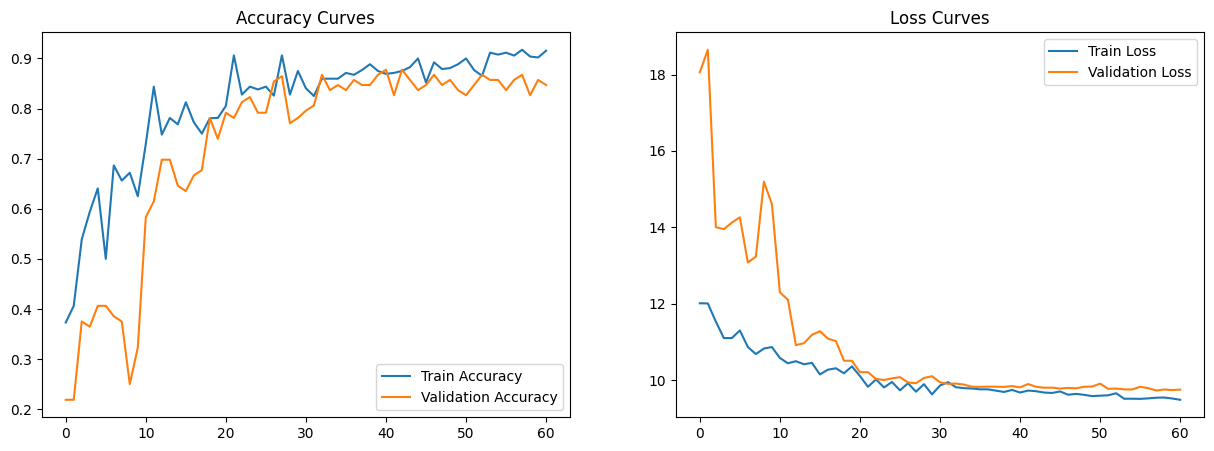

In [15]:
# ======================
# Visualization
# ======================
# Combine training histories
full_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss']
}

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(full_history['accuracy'], label='Train Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step


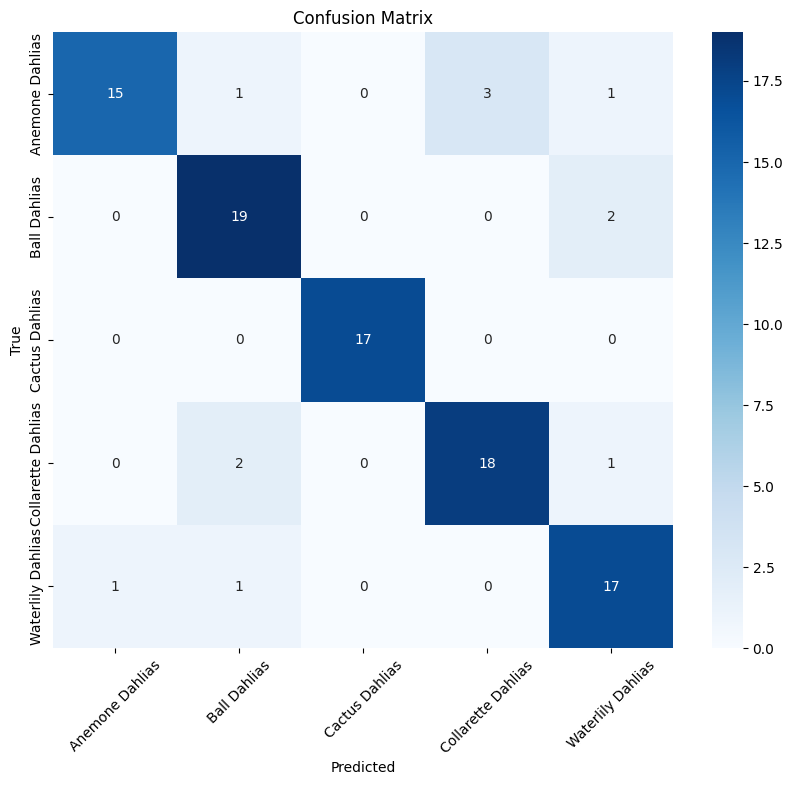

In [16]:
# Confusion Matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)
class_names = list(train_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.show()


In [19]:

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report:
                    precision    recall  f1-score   support

   Anemone Dahlias       0.94      0.75      0.83        20
      Ball Dahlias       0.83      0.90      0.86        21
    Cactus Dahlias       1.00      1.00      1.00        17
Collarette Dahlias       0.86      0.86      0.86        21
 Waterlily Dahlias       0.81      0.89      0.85        19

          accuracy                           0.88        98
         macro avg       0.89      0.88      0.88        98
      weighted avg       0.88      0.88      0.88        98



In [20]:
# Sample Predictions
sample_images, sample_labels = next(test_generator)
preds = model.predict(sample_images)
pred_labels = preds.argmax(axis=1)
true_labels = sample_labels.argmax(axis=1)

plt.figure(figsize=(20, 12))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]} ({preds[i].max():.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [18]:

# ======================
# Model Evaluation
# ======================
loss, accuracy = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.8635 - loss: 9.8473

Final Test Accuracy: 87.76%
Test Loss: 9.8091


In [21]:
# Save Final Model
model.save('dahlia_vgg_final.h5')